1 VOICE

https://ai.google.dev/gemini-api/docs/speech-generation?hl=vi

Các mô hình TTS chỉ có thể nhận dữ liệu đầu vào là văn bản và tạo dữ liệu đầu ra là âm thanh.

Một phiên TTS có giới hạn cửa sổ ngữ cảnh là 32 nghìn token.

Xem phần Ngôn ngữ để biết thông tin về ngôn ngữ được hỗ trợ.

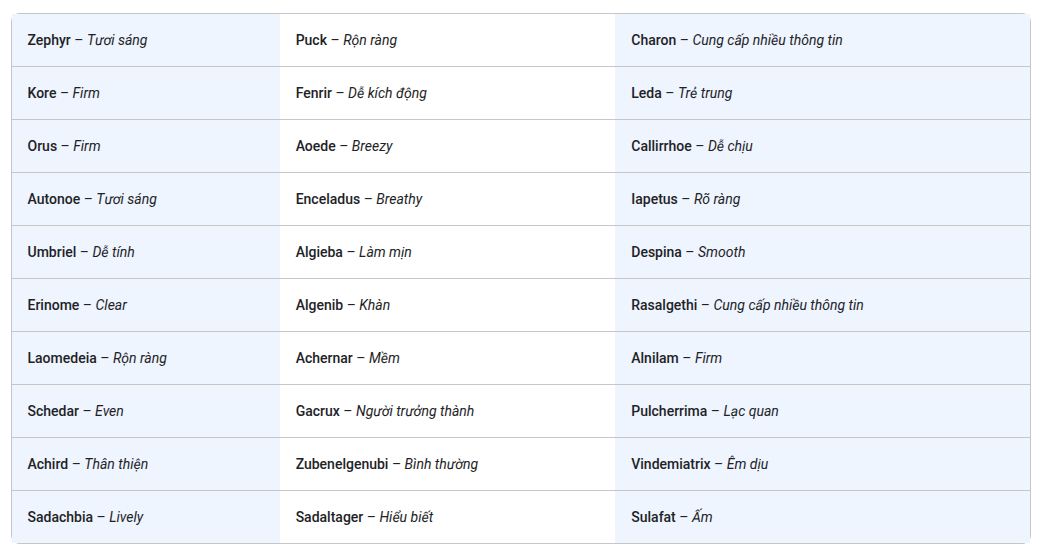

In [2]:
from openai import OpenAI
from datetime import datetime, timezone, timedelta
import os
import json

# --- Cấu hình ---
AI_API_BASE = "https://api.thucchien.ai/v1"
AI_API_KEY = "sk-YzYUqhbM9WskmD2AQDUXJQ"
MODEL = "gemini-2.5-flash-preview-tts"

client = OpenAI(
    api_key=AI_API_KEY,
    base_url=AI_API_BASE
)

# --- Cấu hình log & thư mục ---
AUDIO_DIR = "results_audio"
LOG_FILE_SUMMARY = "logs/audio_summary.log"
os.makedirs(AUDIO_DIR, exist_ok=True)
os.makedirs("logs", exist_ok=True)

# --- Prompt / text đầu vào ---
text_input = "Nam nói với giọng cực kỳ buồn: Cái địt con mẹ chúng mày!"
voice = [
    "Zephyr", #0
    "Puck", #1
    "Charon", #2
    "Kore", #3
    "Fenrir", #4
    "Leda", #5
    "Orus", #6
    "Aoede", #7
    "Callirrhoe", #8
    "Autonoe", #9
    "Enceladus", #10
    "Iapetus", #11
    "Umbriel", #12
    "Algieba", #13
    "Despina", #14
    "Erinome", #15
    "Algenib", #16
    "Rasalgethi", #17
    "Laomedeia", #18
    "Achernar", #19
    "Alnilam", #20
    "Schedar", #21
    "Gacrux", #22
    "Pulcherrima", #23
    "Achird", #24
    "Zubenelgenubi", #25
    "Vindemiatrix", #26
    "Sadachbia", #27
    "Sadaltager", #28
    "Sulafat" #29
]

# --- Thiết lập múi giờ Hà Nội ---
hanoi_tz = timezone(timedelta(hours=7))
timestamp = datetime.now(hanoi_tz).strftime("%Y-%m-%d %H:%M:%S")
timestamp_safe = datetime.now(hanoi_tz).strftime("%Y%m%d_%H%M%S")

# --- Gọi API ---
response = client.audio.speech.create(
    model=MODEL,
    input=text_input,
    voice=voice[4]
)

# --- Lưu file âm thanh ---
audio_filename = f"audio_{timestamp_safe}.mp3"
save_path = os.path.join(AUDIO_DIR, audio_filename)
with open(save_path, "wb") as f:
    f.write(response.read())

print(f"✅ File âm thanh đã lưu tại: {save_path}")

# --- Ghi log ---
log_entry = {
    "timestamp": timestamp,
    "model": MODEL,
    "voice": voice,
    "input_text": text_input,
    "saved_audio": save_path
}

with open(LOG_FILE_SUMMARY, "a", encoding="utf-8") as f:
    f.write(f"\n=================== 🕒 {timestamp} (UTC+7) ===================\n\n")
    f.write("🔊 Input:\n")
    f.write(text_input + "\n\n")
    f.write(f"🎙️ Voice: {voice}\n")
    f.write(f"📊 Model: {MODEL}\n")
    f.write(f"🎧 File âm thanh: {save_path}\n")
    f.write("\n======================================================================\n")

print(f"📝 Đã ghi log tóm tắt vào {LOG_FILE_SUMMARY}")


✅ File âm thanh đã lưu tại: results_audio\audio_20251022_232013.mp3
📝 Đã ghi log tóm tắt vào logs/audio_summary.log


---

Noi nhieu giong voi gemini

* `channels = 1`: số **kênh âm thanh**.

  * `1` = mono (1 kênh, thường dùng trong TTS).
  * `2` = stereo (2 kênh, trái và phải).
    → API `audio/L16;codec=pcm;rate=24000` không nói rõ số kênh, nên mặc định là **mono (1)**.

* `sample_width = 2`: số **byte cho mỗi mẫu âm thanh**.

  * `L16` = Linear PCM 16-bit → mỗi mẫu = 16 bit = 2 byte.
  * `L24` = 3 byte, `L8` = 1 byte.
    → Bạn có thể suy ra từ phần đầu MIME:

  ```
  audio/L16 → sample_width = 2
  audio/L8  → sample_width = 1
  ```

Tóm lại:

* `channels` = 1 (vì không khai báo khác).
* `sample_width` = 2 (vì `L16` chỉ ra 16-bit PCM).


In [5]:
from datetime import datetime, timezone, timedelta
import os
import json
import requests
import base64
import wave

# --- Cấu hình ---
AI_API_BASE = "https://api.thucchien.ai/gemini/v1beta"
AI_API_KEY = "sk-YzYUqhbM9WskmD2AQDUXJQ"
MODEL = "gemini-2.5-flash-preview-tts:generateContent"
ENDPOINT = f"{AI_API_BASE}/models/{MODEL}"

# --- Cấu hình thư mục & log ---
AUDIO_DIR = "results_audio_multispeaker"
LOG_FILE_SUMMARY = "logs/audio_multispeaker_summary.log"
os.makedirs(AUDIO_DIR, exist_ok=True)
os.makedirs("logs", exist_ok=True)

# --- Setting đầu vào đa giọng nói ---
channels = 1
sample_width = 2  # 16-bit PCM = 2 bytes
sample_rate = 24000

# --- Nội dung đầu vào ---
text_input = """Giả sử hai người, Joe và Jane, đang trò chuyện với nhau. Joe mệt mỏi sau một ngày dài làm việc và muốn hỏi thăm Jane về ngày của cô ấy. Jane thì rất vui vẻ và hào hứng chia sẻ về những điều thú vị đã xảy ra trong ngày hôm nay.:
Speaker1: Xin chào Jane! Hôm nay bạn thế nào?
Speaker2: Chào Joe! Mình rất vui hôm nay. Còn bạn thì sao?"""

speaker_voice_configs = [
    {
        "speaker": "Joe",
        "voiceConfig": {"prebuiltVoiceConfig": {"voiceName": "Kore"}}
    },
    {
        "speaker": "Jane",
        "voiceConfig": {"prebuiltVoiceConfig": {"voiceName": "Puck"}}
    }
]

payload = {
    "contents": [{
        "parts": [{"text": text_input}]
    }],
    "generationConfig": {
        "responseModalities": ["AUDIO"],
        "speechConfig": {
            "multiSpeakerVoiceConfig": {
                "speakerVoiceConfigs": speaker_voice_configs
            }
        }
    }
}

headers = {
    "x-goog-api-key": AI_API_KEY,
    "Content-Type": "application/json"
}

# --- Thiết lập múi giờ Hà Nội ---
hanoi_tz = timezone(timedelta(hours=7))
timestamp = datetime.now(hanoi_tz).strftime("%Y-%m-%d %H:%M:%S")
timestamp_safe = datetime.now(hanoi_tz).strftime("%Y%m%d_%H%M%S")

# --- Gọi API ---
response = requests.post(ENDPOINT, headers=headers, json=payload)

if response.status_code != 200:
    print(f"❌ Lỗi API ({response.status_code}): {response.text}")
    exit(1)

# --- Phân tích JSON ---
try:
    result_json = response.json()
    # mime_type = result_json["candidates"][0]["content"]["parts"][0]["inlineData"]["mime_type"]
    audio_b64 = result_json["candidates"][0]["content"]["parts"][0]["inlineData"]["data"]
except Exception as e:
    print("❌ Không thể đọc dữ liệu âm thanh từ phản hồi API.")
    print(response.text)
    exit(1)
#
# # --- Giải mã base64 và lưu file ---
# if "rate=" in mime_type:
#     try:
#         rate_str = mime_type.split("rate=")[1].split(";")[0]
#         sample_rate = int(rate_str)
#     except:
#         sample_rate = 24000
# else:
#     sample_rate = 24000

audio_data = base64.b64decode(audio_b64)
audio_filename = f"audio_multispeaker_{timestamp_safe}.wav"  # Có thể đổi sang .mp3 nếu cần
save_path = os.path.join(AUDIO_DIR, audio_filename)

with wave.open(save_path, "wb") as f:
    f.setnchannels(channels)
    f.setframerate(sample_rate)
    f.setsampwidth(sample_width)
    f.writeframes(audio_data)

print(f"✅ File âm thanh đã lưu tại: {save_path}")

# --- Ghi log ---
log_entry = {
    "timestamp": timestamp,
    "model": MODEL,
    "input_text": text_input,
    "speakers": speaker_voice_configs,
    "saved_audio": save_path
}

with open(LOG_FILE_SUMMARY, "a", encoding="utf-8") as f:
    f.write(f"\n=================== 🕒 {timestamp} (UTC+7) ===================\n\n")
    f.write("🎙️ Input:\n")
    f.write(text_input + "\n\n")
    f.write("👥 Speakers:\n")
    for s in speaker_voice_configs:
        f.write(f"   - {s['speaker']}: {s['voiceConfig']['prebuiltVoiceConfig']['voiceName']}\n")
    f.write(f"\n📊 Model: {MODEL}\n")
    f.write(f"🎧 File âm thanh: {save_path}\n")
    f.write("\n======================================================================\n")

print(f"📝 Đã ghi log tóm tắt vào {LOG_FILE_SUMMARY}")


✅ File âm thanh đã lưu tại: results_audio_multispeaker/audio_multispeaker_20251022_231330.wav
📝 Đã ghi log tóm tắt vào logs/audio_multispeaker_summary.log
